### Note

If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

---

# Importing Libraries

In [1]:
!python --version

Python 3.7.10


In [2]:
import matplotlib.pyplot as plt #graph
import numpy as np #matrix multiplication
import pandas as pd #dataframe 
import seaborn as sns #graph
import cv2 #work with images
import tensorflow as tf #algorithms
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tqdm import tqdm #loading bar
import os #load an existing file
from sklearn.utils import shuffle #to shuffle
from sklearn.model_selection import train_test_split #to divide traning and testing
from tensorflow.keras.applications import EfficientNetB0 #ai archietecture
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint # to avoid overfitting
from sklearn.metrics import classification_report,confusion_matrix #to find accuracy 
import ipywidgets as widgets 
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Color

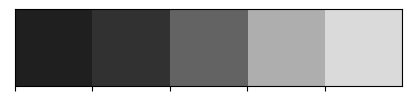

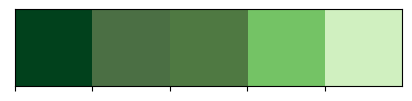

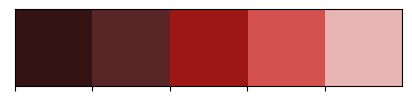

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('archive','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('archive','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 91.20it/s] 


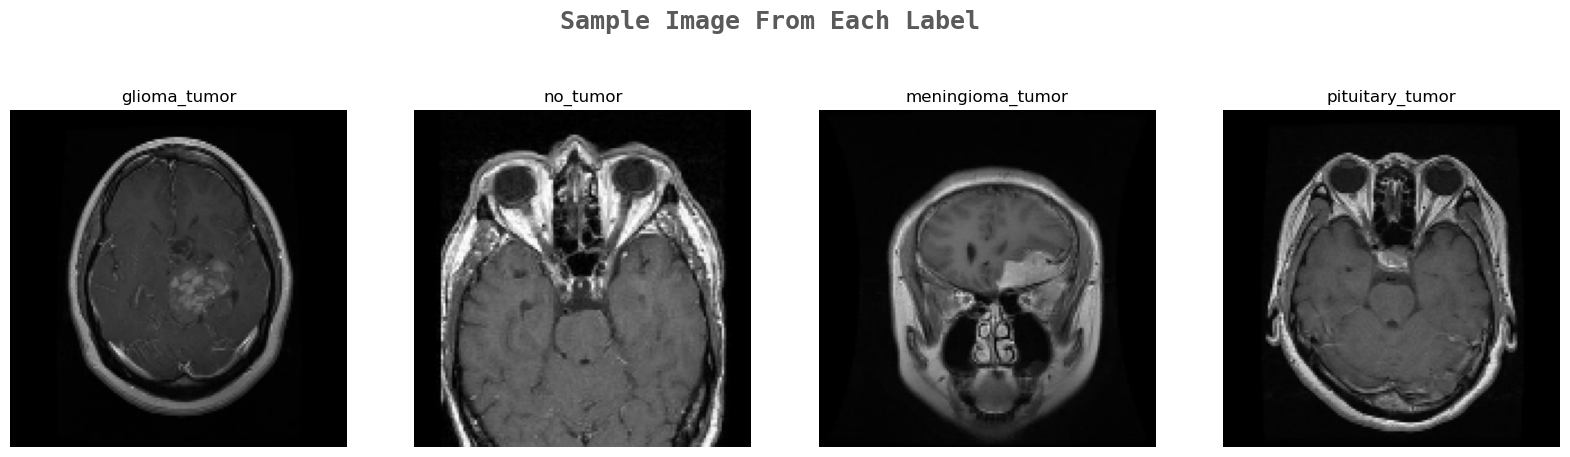

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [12]:
#novelty
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

We finally compile our model.

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [16]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32)
                #    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 159s 2s/step - loss: 0.4638 - accuracy: 0.8165 - val_loss: 0.4719 - val_accuracy: 0.8571
Epoch 2/12
83/83 [==============================] - 159s 2s/step - loss: 0.2030 - accuracy: 0.9315 - val_loss: 0.7454 - val_accuracy: 0.8129
Epoch 3/12
83/83 [==============================] - 160s 2s/step - loss: 0.1391 - accuracy: 0.9588 - val_loss: 0.2918 - val_accuracy: 0.9320
Epoch 4/12
83/83 [==============================] - 167s 2s/step - loss: 0.0633 - accuracy: 0.9781 - val_loss: 0.1700 - val_accuracy: 0.9490
Epoch 5/12
83/83 [==============================] - 159s 2s/step - loss: 0.0631 - accuracy: 0.9807 - val_loss: 0.4817 - val_accuracy: 0.8980
Epoch 6/12
83/83 [==============================] - 164s 2s/step - loss: 0.0595 - accuracy: 0.9781 - val_loss: 0.3302 - val_accuracy: 0.9116
Epoch 7/12
83/83 [==============================] - 175s 2s/step - loss: 0.0751 - accuracy: 0.9750 - val_loss: 0.2611 - val_accuracy: 0.9422
Epoch 8/12
83

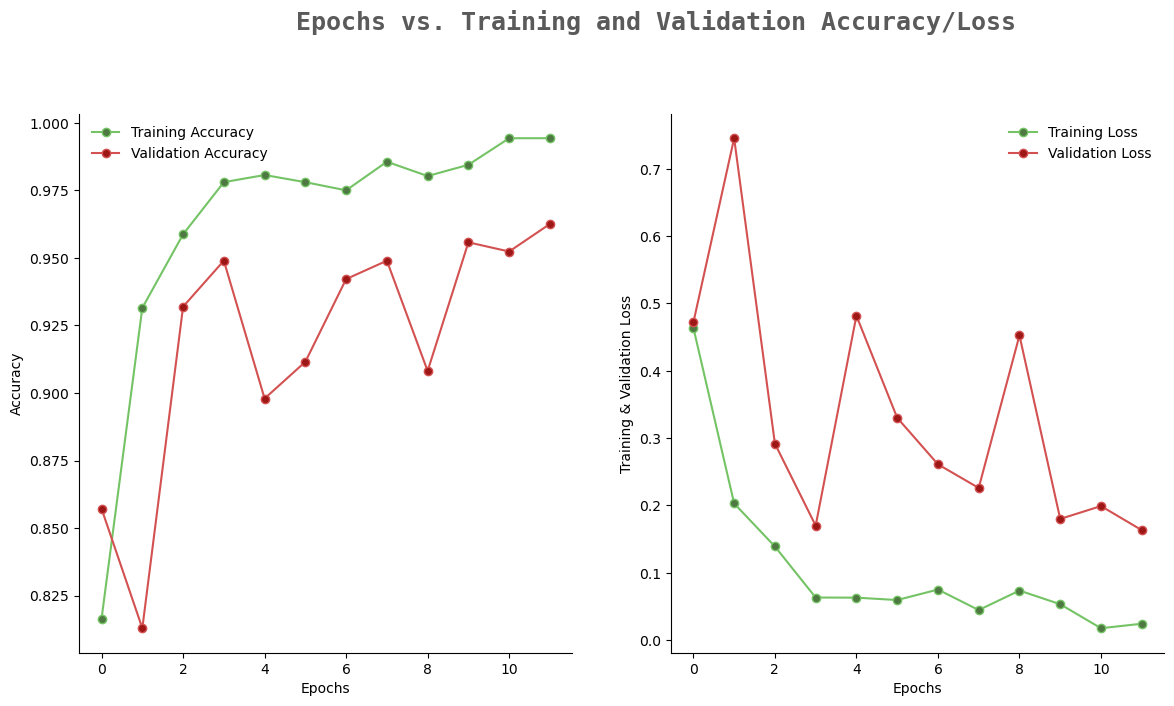

In [17]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 8s 581ms/step


---

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [19]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        93
           1       0.94      1.00      0.97        51
           2       0.92      0.99      0.95        96
           3       1.00      0.97      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



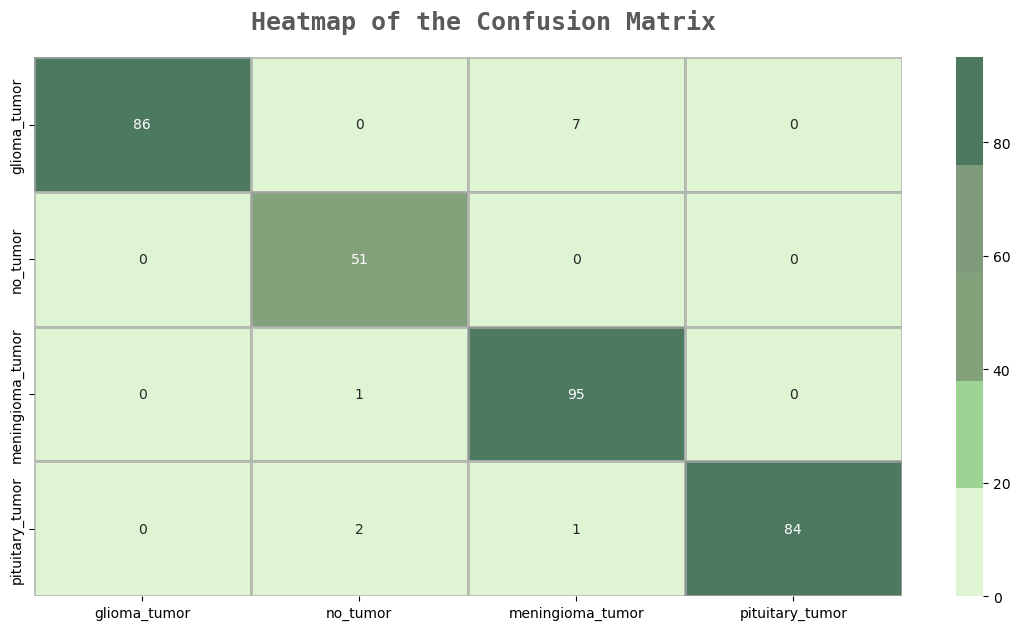

In [20]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

In [21]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [22]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])